### Description

### load 

In [5]:
import os
import random 
import pickle
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

root_path = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
# to import src is necessary to append the root_path to the path
#sys.path.append(root_path)

data_path = os.path.join(root_path,'data')
results_path = os.path.join(root_path,'results')

### Define global variables

In [6]:
WITH_STEMMING = True
REMOVE_STOPWORDS = True
MINIMUM_WORDS_PER_PHRASE = 0
GROUP = -1
SEED = 10
num_topics = 60
random.seed(SEED)

In [7]:
df = pd.read_excel('IBL_topic_distribution_by_block_with_phrase_before_and_after_time_utterance_minimum_0_words_with_stemming.xlsx')

In [8]:
df.columns

Index(['utterance_before_Topic_1', 'utterance_before_Topic_2',
       'utterance_before_Topic_3', 'utterance_before_Topic_4',
       'utterance_before_Topic_5', 'utterance_before_Topic_6',
       'utterance_before_Topic_7', 'utterance_before_Topic_8',
       'utterance_before_Topic_9', 'utterance_before_Topic_10',
       ...
       'utterance_after_Topic_60', 'phase', 'phase_1', 'phase_2', 'phase_3',
       'phase_4', 'phase_5', 'utterance', 'length utterance',
       'utterance_time'],
      dtype='object', length=189)

### split dataset

In [9]:
the_keys = list(set(df['phase']))
for key in the_keys:
    n = list(df.phase.values).count(key)
    print("key {}, total {}".format(key,n))

key 1, total 95
key 2, total 41
key 3, total 119
key 4, total 40
key 5, total 157


In [10]:
97+12+70+18+65

262

In [11]:
(97+12+70+18+65)*11/(5*7)

82.34285714285714

In [12]:
trainset = {}
testset = {}
for name, group in df.groupby(['phase']):
    trainset[name]=[]
    testset[name]=[]
    n = len(group)
    ra = random.sample(range(n),int(n*0.2))
    print("test set phase {}: {}".format(name,int(n*0.2)))
    count = 0
    group = group.reset_index()
    for i,row in group.iterrows():
        if i in ra:
            count+=1
            testset[name].append(row.values)
        else:
            trainset[name].append(row.values)


test set phase 1: 19
test set phase 2: 8
test set phase 3: 23
test set phase 4: 8
test set phase 5: 31


In [13]:
filter_rows = list(range(1,181))+[188,189]
#filter_labels = [3601]

In [14]:
def get_data_from_dict(a_dict):
    y = []
    X = []
    for key in a_dict:
        rows = a_dict[key]
        for row in rows:
            X.append(row[filter_rows])
            y.append(key)
    return X,y

In [15]:
X_train,y_train = get_data_from_dict(trainset)
X_test,y_test = get_data_from_dict(testset)

In [16]:
print(y_test.count(4))
print(len(X_train[0]))

8
182


### Train decision tree


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = DecisionTreeClassifier(random_state=SEED).fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.45


In [18]:
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

In [19]:
dot_data = tree.export_graphviz(clf, class_names=['1', '2','3','4','5'], out_file=None,max_depth=4)
graph = graphviz.Source(dot_data)
graph.render('test-output/tree_phases_5_classes_before_after_blocks.gv', view=True)

'test-output/tree_phases_5_classes_before_after_blocks.gv.pdf'

In [20]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 7  1  2  1  8]
 [ 1  3  0  0  4]
 [ 2  2 13  0  6]
 [ 0  0  1  4  3]
 [ 9  2  6  1 13]]
              precision    recall  f1-score   support

           1       0.37      0.37      0.37        19
           2       0.38      0.38      0.38         8
           3       0.59      0.57      0.58        23
           4       0.67      0.50      0.57         8
           5       0.38      0.42      0.40        31

   micro avg       0.45      0.45      0.45        89
   macro avg       0.48      0.45      0.46        89
weighted avg       0.46      0.45      0.45        89



### Train without stem

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.64
Accuracy of K-NN classifier on test set: 0.53


In [23]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[11  4  1  1  2]
 [ 1  0  2  3  2]
 [ 5  0 18  0  0]
 [ 1  0  3  2  2]
 [ 7  1  6  1 16]]
              precision    recall  f1-score   support

           1       0.44      0.58      0.50        19
           2       0.00      0.00      0.00         8
           3       0.60      0.78      0.68        23
           4       0.29      0.25      0.27         8
           5       0.73      0.52      0.60        31

   micro avg       0.53      0.53      0.53        89
   macro avg       0.41      0.43      0.41        89
weighted avg       0.53      0.53      0.52        89



In [24]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.49
Accuracy of GNB classifier on test set: 0.31


In [25]:
pred = gnb.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[4 4 3 5 3]
 [1 3 1 3 0]
 [2 5 9 6 1]
 [0 3 1 4 0]
 [5 7 3 8 8]]
              precision    recall  f1-score   support

           1       0.33      0.21      0.26        19
           2       0.14      0.38      0.20         8
           3       0.53      0.39      0.45        23
           4       0.15      0.50      0.24         8
           5       0.67      0.26      0.37        31

   micro avg       0.31      0.31      0.31        89
   macro avg       0.36      0.35      0.30        89
weighted avg       0.47      0.31      0.34        89



C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


In [26]:
svm = SVC(decision_function_shape='ovr',gamma=1,kernel='rbf',random_state=SEED,C= 100.0)#class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.99
Accuracy of SVM classifier on test set: 0.51


In [27]:
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[15  0  1  0  3]
 [ 2  1  0  4  1]
 [ 2  0 14  1  6]
 [ 1  1  2  1  3]
 [ 7  4  3  3 14]]
              precision    recall  f1-score   support

           1       0.56      0.79      0.65        19
           2       0.17      0.12      0.14         8
           3       0.70      0.61      0.65        23
           4       0.11      0.12      0.12         8
           5       0.52      0.45      0.48        31

   micro avg       0.51      0.51      0.51        89
   macro avg       0.41      0.42      0.41        89
weighted avg       0.51      0.51      0.50        89



In [28]:
from sklearn.svm import LinearSVC
svc = LinearSVC(random_state=SEED,max_iter=3000)#,class_weight={1:0.4,2:0.4,3:0.4,4:0.5,5:0.3})
svc.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svc.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.63
Accuracy of SVM classifier on test set: 0.54


In [29]:
pred = svc.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[11  0  3  0  5]
 [ 1  0  0  4  3]
 [ 5  0 15  0  3]
 [ 0  0  1  2  5]
 [ 7  0  1  3 20]]
              precision    recall  f1-score   support

           1       0.46      0.58      0.51        19
           2       0.00      0.00      0.00         8
           3       0.75      0.65      0.70        23
           4       0.22      0.25      0.24         8
           5       0.56      0.65      0.60        31

   micro avg       0.54      0.54      0.54        89
   macro avg       0.40      0.43      0.41        89
weighted avg       0.51      0.54      0.52        89



C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Optimize params

### Build classifier per class

In [36]:
def get_data_from_dict_filter(a_dict,filter_phase):
    y = []
    X = []
    for key in a_dict:
        rows = a_dict[key]
        for row in rows:
            X.append(row[filter_rows])
            if filter_phase == key:
                y.append(key)
            else:
                y.append(0)
    return X,y

### classify class 1

In [71]:
#trainset,testset = split_sets_key(clean_phrases,1)
X_train,y_train = get_data_from_dict_filter(trainset,1)
X_test,y_test = get_data_from_dict_filter(testset,1)

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [72]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.86
Accuracy of SVM classifier on test set: 0.75
[[29  9]
 [ 4  9]]
              precision    recall  f1-score   support

           0       0.88      0.76      0.82        38
           1       0.50      0.69      0.58        13

   micro avg       0.75      0.75      0.75        51
   macro avg       0.69      0.73      0.70        51
weighted avg       0.78      0.75      0.76        51



In [73]:
svm = LinearSVC(random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.83
Accuracy of SVM classifier on test set: 0.73
[[34  4]
 [10  3]]
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        38
           1       0.43      0.23      0.30        13

   micro avg       0.73      0.73      0.73        51
   macro avg       0.60      0.56      0.56        51
weighted avg       0.69      0.73      0.69        51



### classify class 2

In [64]:
X_train,y_train = get_data_from_dict_filter(trainset,2)
X_test,y_test = get_data_from_dict_filter(testset,2)


C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [70]:
svm = SVC(decision_function_shape='ovr',gamma='scale',C= 10000000.0, random_state=SEED,class_weight={0:0.06,2:3.93})#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 0.90
[[45  3]
 [ 2  1]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        48
           2       0.25      0.33      0.29         3

   micro avg       0.90      0.90      0.90        51
   macro avg       0.60      0.64      0.62        51
weighted avg       0.92      0.90      0.91        51



### Classify class 3

In [60]:
X_train,y_train = get_data_from_dict_filter(trainset,3)
X_test,y_test = get_data_from_dict_filter(testset,3)

In [61]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED,class_weight={0:0.36,3:0.63})#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.90
Accuracy of SVM classifier on test set: 0.75
[[27 10]
 [ 3 11]]
              precision    recall  f1-score   support

           0       0.90      0.73      0.81        37
           3       0.52      0.79      0.63        14

   micro avg       0.75      0.75      0.75        51
   macro avg       0.71      0.76      0.72        51
weighted avg       0.80      0.75      0.76        51



### Classify class 4

In [59]:
X_train,y_train = get_data_from_dict_filter(trainset,4)
X_test,y_test = get_data_from_dict_filter(testset,4)
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED,class_weight={0:0.36,4:0.63})#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 0.98
[[49  0]
 [ 1  1]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           4       1.00      0.50      0.67         2

   micro avg       0.98      0.98      0.98        51
   macro avg       0.99      0.75      0.83        51
weighted avg       0.98      0.98      0.98        51



### classify class 5

In [110]:
X_train,y_train = get_data_from_dict_filter(trainset,5)
X_test,y_test = get_data_from_dict_filter(testset,5)
print(y_train.count(0)*100.0/len(y_train))

63.03317535545024


C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


In [111]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED,probability=True)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred5 = svm.predict(X_test)
print(confusion_matrix(y_test, pred5))
print(classification_report(y_test, pred5))

Accuracy of SVM classifier on training set: 0.81
Accuracy of SVM classifier on test set: 0.63
[[25  7]
 [12  7]]
              precision    recall  f1-score   support

           0       0.68      0.78      0.72        32
           5       0.50      0.37      0.42        19

   micro avg       0.63      0.63      0.63        51
   macro avg       0.59      0.57      0.57        51
weighted avg       0.61      0.63      0.61        51



In [113]:
clf = DecisionTreeClassifier(random_state=SEED).fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
dot_data = tree.export_graphviz(clf, class_names=['0','5'], out_file=None,max_depth=4)
graph = graphviz.Source(dot_data)
graph.render('test-output/tree_5_classes_before_after_blocks.gv', view=True)

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.47


'test-output/tree_5_classes_before_after_blocks.gv.pdf'

In [58]:
svm = SVC(decision_function_shape='ovr',gamma='scale',C=100,random_state=SEED,probability=True)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred5 = svm.predict(X_test)
print(confusion_matrix(y_test, pred5))
print(classification_report(y_test, pred5))

Accuracy of SVM classifier on training set: 0.81
Accuracy of SVM classifier on test set: 0.65
[[27  5]
 [13  6]]
              precision    recall  f1-score   support

           0       0.68      0.84      0.75        32
           5       0.55      0.32      0.40        19

   micro avg       0.65      0.65      0.65        51
   macro avg       0.61      0.58      0.57        51
weighted avg       0.63      0.65      0.62        51



In [48]:
list(zip(svm.predict_proba(X_test),pred5,y_test))

[(array([0.79348814, 0.20651186]), 0, 0),
 (array([0.48619073, 0.51380927]), 5, 0),
 (array([0.7292252, 0.2707748]), 0, 0),
 (array([0.71984232, 0.28015768]), 0, 0),
 (array([0.74780275, 0.25219725]), 0, 0),
 (array([0.8469042, 0.1530958]), 0, 0),
 (array([0.66276976, 0.33723024]), 0, 0),
 (array([0.86171509, 0.13828491]), 0, 0),
 (array([0.88877352, 0.11122648]), 0, 0),
 (array([0.56234844, 0.43765156]), 0, 0),
 (array([0.78996471, 0.21003529]), 0, 0),
 (array([0.88209992, 0.11790008]), 0, 0),
 (array([0.30077176, 0.69922824]), 5, 0),
 (array([0.61787374, 0.38212626]), 0, 0),
 (array([0.85438009, 0.14561991]), 0, 0),
 (array([0.74379469, 0.25620531]), 0, 0),
 (array([0.47778764, 0.52221236]), 5, 0),
 (array([0.71098029, 0.28901971]), 0, 0),
 (array([0.59815393, 0.40184607]), 0, 0),
 (array([0.93932739, 0.06067261]), 0, 0),
 (array([0.74173037, 0.25826963]), 0, 0),
 (array([0.89115358, 0.10884642]), 0, 0),
 (array([0.93299114, 0.06700886]), 0, 0),
 (array([0.89724232, 0.10275768]), 0, 

#### Regression


In [50]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [55]:
#clf = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42,class_weight={0:0.36,5:0.63}).fit(X_train, y_train)
X_train,y_train = get_data_from_dict_filter(trainset,5)
X_test,y_test = get_data_from_dict_filter(testset,5)
print(y_train.count(0)*100.0/len(y_train))
clf = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42,class_weight={0:0.36,5:0.63}).fit(X_train, y_train)

63.03317535545024


In [56]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[25  7]
 [ 4 15]]
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        32
           5       0.68      0.79      0.73        19

   micro avg       0.78      0.78      0.78        51
   macro avg       0.77      0.79      0.78        51
weighted avg       0.79      0.78      0.79        51



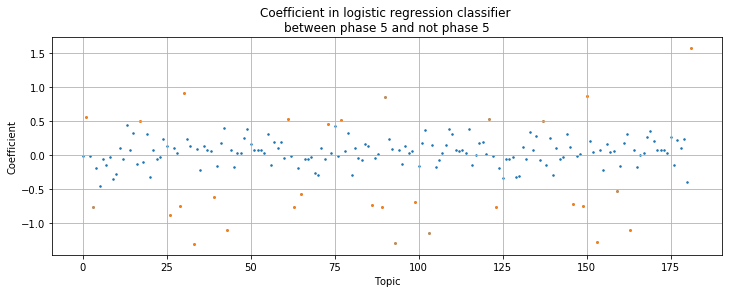

In [130]:
f = plt.figure(figsize=(12,4))
plt.scatter(range(len(clf.coef_[0])),clf.coef_[0],s=2.3)
out_std = [x for x in clf.coef_[0] if np.abs(x) > 0.45]
out_std_i = [i for i,x in enumerate(clf.coef_[0]) if np.abs(x) > 0.45]
plt.scatter(out_std_i,out_std,s=2.8)
#plt.xticks(range(0,len(clf.coef_[0])+1,2),rotation=90)
#plt.ylim(-1,1)
plt.xlabel('Topic')
plt.ylabel('Coefficient')
plt.title('Coefficient in logistic regression classifier \nbetween phase 5 and not phase 5')
plt.grid()

In [49]:
np.round(np.mean(clf.coef_[0]),4)
np.std(clf.coef_[0])

0.45425204108939343

### Important Topics

In [131]:
a_name = 'lda_textbooks_chunksize_alpha_auto_seed_{}_{}_{}_{}.pickle'.format(SEED,num_topics,REMOVE_STOPWORDS,WITH_STEMMING)
model_file = os.path.join(results_path,'lda_models',a_name)
with open(model_file,'rb') as f:
    ldamodel = pickle.load(f)

C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [132]:
les_ids = np.argsort(np.abs(clf.coef_[0]))[-20:]

In [133]:
list(zip(np.argsort(np.abs(clf.coef_[0]))[-20:],clf.coef_[0][les_ids]))

[(99, -0.6815322803154235),
 (146, -0.7171967159647431),
 (86, -0.7337224145596986),
 (149, -0.7475518935972536),
 (29, -0.7478563624813036),
 (3, -0.7632775678656876),
 (123, -0.764096928595131),
 (63, -0.7645231879861699),
 (89, -0.7674327716717719),
 (90, 0.8550722660477563),
 (150, 0.8720556724783496),
 (26, -0.8736327238736886),
 (30, 0.9188805895423755),
 (43, -1.09630313428274),
 (163, -1.1047489733133293),
 (103, -1.1379291483525755),
 (153, -1.2802503956679847),
 (93, -1.2862417020779864),
 (33, -1.3056465843393474),
 (181, 1.5762875761075135)]

In [57]:
print(df.columns[103])
print(df.columns[153])
print(df.columns[93])
print(df.columns[33])
print(df.columns[181])

utterance_Topic_44
utterance_after_Topic_34
utterance_Topic_34
utterance_before_Topic_34
phase_1


Topics

In [55]:
ldamodel.show_topic(33)

[('NUMBER', 0.6798587),
 ('a', 0.08793937),
 ('b', 0.07294916),
 ('c', 0.04292229),
 ('d', 0.022924542),
 ('lask', 0.007425218),
 ('+', 0.005417729),
 ('yhtälö', 0.003409941),
 ('kirj', 0.00226472),
 ('A_NAME', 0.002003389)]

In [118]:
ldamodel.show_topic(43)

[('EQUAL_SYMBOL', 0.16383563),
 ('n', 0.10167014),
 ('e', 0.08339013),
 ('NUMBER', 0.07767182),
 ('v', 0.050334003),
 ('k', 0.05002136),
 ('s', 0.045941617),
 ('m', 0.044747524),
 ('T_', 0.04445801),
 ('o', 0.035047248)]

In [131]:
ldamodel.show_topic(30)

[('a', 0.0762239),
 ('b', 0.031992134),
 ('c', 0.026608875),
 ('e', 0.023899583),
 ('oike', 0.01626492),
 ('kuva', 0.014383731),
 ('rin', 0.014164257),
 ('tulo', 0.012914545),
 ('kirj', 0.012067141),
 ('suuremp', 0.0119486265)]

### Plot phrases

In [74]:
print(len(X_train))
print(len(X_train[0]))

211
182


In [75]:
amat2 = np.ones((len(X_train[0]),len(X_train)))
for i in range(len(X_train[0])):
    lali = []
    for element in X_train:
        lali.append(element[i])
    amat2[i,:] =np.array(lali)
    
means = [np.mean(amat2[i]) for i in range(len(X_train[0]))]

X_train_centered = []
for i in range(len(X_train)):
    row = []
    for j in range(len(X_train[0])):
        row.append(X_train[i][j]-means[j])
    X_train_centered.append(row)

In [98]:
# make 3-class dataset for classification
pca = PCA(n_components=4)
pca.fit(X_train_centered)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [99]:
sum(pca.explained_variance_ratio_)

0.6105356691649104

In [100]:
v_1 = pca.components_[0]
v_2 = pca.components_[1]

In [101]:
np.argsort(np.abs(v_1))

array([145,  25,  85,   6,  66, 126, 132,  12,  72,  44, 104, 164,  59,
       174,  54, 114, 139, 176,  79,  56, 116,  19, 166, 112,  52, 172,
        97,  37, 157, 161, 101,  41, 179,  57, 119,  53, 113, 173, 106,
        16, 136,  76, 124,   4,  64,  28,  88, 148, 177, 117,  24, 144,
        84, 150, 131,  67,  30,  46, 134,  14,  11,  71,  22,  74,  82,
        45, 165, 105,   7, 127, 142,  49, 169,  31, 151,  91, 109, 100,
        40, 160, 154,  62,   2, 122,  90, 125,   5,  65,  47,  94, 167,
       107,  34, 146,  73, 143, 133,  13,  23,  83,  80,  77, 137,  17,
       171,  51, 111,  58, 178, 118, 140, 121,   1,  61,  20, 128,   8,
        68,  29,  60,   0, 120,  95,  35,  32, 152,  92,  86,  26, 135,
       155,  89,  75,  96, 156, 149,  36,  15, 102,  42, 162,  78, 138,
        18,  39,  99, 159,  81,  21, 141,  69, 129,   9, 180,  27, 147,
       130,  10,  70,  87,  93,  98, 158,  38, 153,  33, 123,   3,  63,
       115,  55, 175, 170, 110,  50, 103, 163,  43, 108,  48, 16

In [102]:
v_1[np.argsort(np.abs(v_1))]

array([-2.50114054e-04, -2.50114148e-04, -2.50114224e-04,  2.65450413e-04,
        2.66077695e-04,  2.66404350e-04, -5.00904379e-04, -5.02973884e-04,
       -5.04730625e-04,  5.18396415e-04,  5.19229863e-04,  5.20669813e-04,
        5.55261911e-04, -5.77095478e-04, -5.77095503e-04, -5.77095512e-04,
        6.45534273e-04, -6.48420307e-04,  6.48764217e-04, -6.48783483e-04,
       -6.48792128e-04,  6.51185247e-04,  6.71193825e-04,  8.35158829e-04,
        8.36083070e-04,  8.42384909e-04, -8.42839366e-04, -8.44388070e-04,
       -8.45708812e-04,  9.40724673e-04,  9.40729867e-04,  9.40839895e-04,
        1.01360113e-03, -1.03281297e-03,  1.11022119e-03, -1.18303447e-03,
       -1.18446945e-03, -1.18484265e-03, -1.21008403e-03,  1.26256948e-03,
        1.26456812e-03,  1.26464216e-03,  1.36174735e-03,  1.37069420e-03,
        1.37185554e-03, -1.43269113e-03, -1.43270326e-03, -1.43272405e-03,
       -1.47618550e-03, -1.48675409e-03,  1.55962289e-03,  1.56265777e-03,
        1.57222595e-03,  

In [103]:
v_2[np.argsort(v_2)]

array([-3.43956308e-01, -3.43912720e-01, -3.43225393e-01, -2.42157977e-01,
       -2.42049401e-01, -2.41253507e-01, -1.22858687e-01, -1.00280850e-01,
       -2.70414546e-02, -2.65748816e-02, -2.57087332e-02, -2.38083547e-02,
       -2.34774015e-02, -2.22867788e-02, -2.22312684e-02, -2.22244353e-02,
       -2.21774979e-02, -2.07078207e-02, -1.87731277e-02, -1.86866539e-02,
       -1.79630940e-02, -1.70169887e-02, -1.62803518e-02, -1.62288076e-02,
       -1.62114164e-02, -1.61022360e-02, -8.86230642e-03, -8.86160104e-03,
       -8.86125118e-03, -7.59313192e-03, -6.89413763e-03, -5.91320487e-03,
       -5.34163524e-03, -4.51882857e-03, -4.44109808e-03, -4.44093010e-03,
       -4.44087402e-03, -3.88585145e-03, -3.85214520e-03, -3.84876235e-03,
       -3.84083092e-03, -3.83276874e-03, -3.82584792e-03, -3.75372189e-03,
       -3.74706020e-03, -3.73786256e-03, -3.72609291e-03, -3.59040277e-03,
       -3.59019091e-03, -3.59017819e-03, -3.57522340e-03, -3.57184861e-03,
       -3.16256870e-03, -

In [104]:
len(X_train)

211

In [105]:
Xdot = np.dot(X_train_centered,pca.components_.T)

In [106]:
pca.components_.shape
Xdot.shape

(211, 4)

In [107]:
colors = {0:'purple',1:'r',2:'b',3:'g',4:'y',5:'black'}


In [108]:
Xdot

array([[-4.14665155e-01,  1.63837302e-01,  2.00554518e-01,
         5.62218626e-02],
       [-4.17715662e-01,  3.64757091e-02,  4.48881207e-02,
        -7.58802073e-02],
       [-3.81988064e-01,  2.17136552e-01, -2.19924881e-01,
         1.22766220e-01],
       [-3.61694033e-01,  2.19906743e-01, -5.81149351e-02,
         6.93025630e-02],
       [-3.32215874e-01, -6.17219542e-02, -2.16801037e-02,
        -1.56046561e-01],
       [-3.15961919e-01, -7.70736468e-02,  1.16237770e-01,
        -1.52255996e-01],
       [-2.26136759e-01, -9.73766196e-02, -2.03692533e-01,
        -5.36862705e-02],
       [-1.82968738e-01, -2.02075204e-01, -6.98760127e-02,
         7.58852642e-03],
       [-9.67582315e-02, -5.79300600e-02, -1.09104554e-01,
        -6.12892754e-02],
       [-1.64248021e-02, -9.76280888e-02,  1.86546990e-01,
        -7.90475081e-02],
       [ 3.17068969e-02, -4.63321835e-02,  8.83475171e-02,
        -1.10321038e-01],
       [ 2.52132899e-01, -1.54836857e-01,  8.85808488e-02,
      

(array([ 5., 11., 25., 38., 41., 55., 25.,  6.,  4.,  1.]),
 array([-0.44846957, -0.3487917 , -0.24911384, -0.14943597, -0.04975811,
         0.04991976,  0.14959762,  0.24927549,  0.34895335,  0.44863122,
         0.54830909]),
 <a list of 10 Patch objects>)

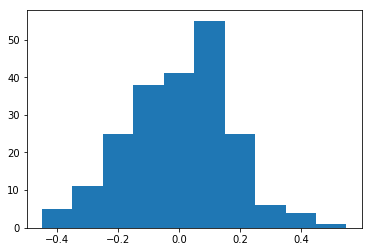

In [109]:
plt.hist([x[1] for x in Xdot])

In [88]:
X_train,y_train1 = get_data_from_dict_filter(trainset,1)
X_train,y_train2 = get_data_from_dict_filter(trainset,2)
X_train,y_train3 = get_data_from_dict_filter(trainset,3)
X_train,y_train4 = get_data_from_dict_filter(trainset,4)
X_train,y_train5 = get_data_from_dict_filter(trainset,5)

In [89]:
pred

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0])

In [90]:
y_train2 = np.array(y_train1)+np.array(y_train2)+np.array(y_train3)+np.array(y_train4)+np.array(y_train5)

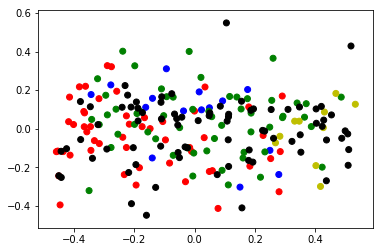

In [91]:
color_label = [colors[i] for i in y_train2]
plt.scatter([x[0] for x in Xdot],[x[1] for x in Xdot],color=color_label)
#plt.ylim(-0.2,0.5)